# Проецирование сцены и однородные координаты

In [1]:
import colorsys

import cv2
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import euler2mat

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

Мы будем пользоваться соглашениями, принятыми в OpenCV:

* камера при проецировании смотрит в положительном направлении оси $z$, ось $y$ при этом направлена вниз, а ось $x$ — вправо;

* соответственно ось $x$ изображения направлена слева направо, а ось $y$ — сверху вниз.

![OpenCV camera](fig/opencv_camera.png)

## Работа с камерой

Работать будем с усеченной пирамидой. Ее вершины в мировой системе координат:

In [2]:
VERTICES = np.array([
    [-1.5, 1, -1.5],
    [1.5, 1, -1.5],
    [1.5, 1, 1.5],
    [-1.5, 1, 1.5],
    [-1, -1, -1],
    [1, -1, -1],
    [1, -1, 1],
    [-1, -1, 1]
])

Ширина и высота кадров, на которых будем рисовать то, что будет у нас получаться:

In [3]:
IMG_WIDTH = 800
IMG_HEIGHT = 600

Функция для рисования спроецированной пирамиды:

In [4]:
def draw_pyramid(points2d, edge_color=(0, 1, 0), vertex_color=(1, 0, 0)):
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
    int_tuples = [tuple(map(int, p)) for p in points2d]
    point_size = 5
    edge_thickness = 2
    edges = [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 4],
        [0, 4],
        [1, 5],
        [2, 6],
        [3, 7]
    ]
    for i, j in edges:
        u = int_tuples[i]
        v = int_tuples[j]
        cv2.line(img, u, v, edge_color, edge_thickness)
    for u in int_tuples:
        cv2.circle(img, u, point_size, vertex_color, -1)
    return img

Данные для тестов и экспериментов:

In [5]:
POINTS2D_0_GT = np.array([
    [252.87281294, 377.17266338],
    [202.22139979, 475.02367959],
    [630.94010768, 430.63945295],
    [466.53488296, 367.11815194],
    [292.82032303, 217.17790557],
    [292.82032303, 161.96317595],
    [535.31524863, 182.88394431],
    [447.70709229, 225.19543471]
])

In [6]:
POINTS2D_1_GT = np.array([
    [272.66377692, 300.43314088],
    [270.08456983, 467.32189182],
    [570.3194412 , 402.81647169],
    [459.52740742, 277.07658349],
    [289.45454807, 167.69783669],
    [296.80086176, 222.53146862],
    [533.65518792, 202.63480128],
    [449.71917197, 159.07976857]
])

### Задача 1. Матрица внутренних параметров камеры и проецирование

Камера задана уже привычной моделью
$$
\begin{pmatrix} x \\ y \\ z\end{pmatrix} \mapsto
\begin{pmatrix} \dfrac{f_x x}{z} + c_x \\ \dfrac{f_y y}{x} + c_y \end{pmatrix}
$$

In [7]:
fx = fy = 400
cx = IMG_WIDTH / 2
cy = IMG_HEIGHT / 2

Создайте матрицу `proj_mat` внутренних параметров камеры размерностью `(4, 4)`.

In [8]:
proj_mat = np.array([
    [fx, 0, cx, 0],
    [0, fy, cy, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

Напишите функцию `project_points3d`, принимающую на вход массив точек размерностью `(N, 3)` и матрицу проекции размерностью `(4, 4)` и возвращающую массив спроецированных точек размерностью `(N, 2)`.

In [9]:
def project_points3d(points3d, pmat):
    points4d = np.hstack((points3d, np.ones((points3d.shape[0], 1))))
    points4d = (pmat @ points4d.T).T
    points4d /= points4d[:, 3].reshape((-1, 1))
    return points4d[:, :2]

Запустите тест.

In [10]:
test_points3d = np.array([[0, 0, 1], [1, 1, 2]])
points2d_ground_truth = np.array([[400, 300], [600, 500]])
assert np.linalg.norm(project_points3d(test_points3d, proj_mat) - points2d_ground_truth) < 1e-5

### Задача 2. Внешние параметры камеры

Пусть в первый момент времени _позиция камеры_ в мировом пространстве задана следующими вектором параллельного переноса и матрицей вращения:

In [11]:
tvec_initial = np.array([4, 0, -1])
rmat_initial = euler2mat(0, np.deg2rad(-75.0), 0)

Напишите функцию `rmat_and_tvec_to_mat4x4`, создающую матрицу трансформации из заданных матрицы вращения и вектора параллельного переноса.

In [12]:
def rmat_and_tvec_to_mat4x4(rmat, tvec):
    mat = np.eye(4)
    mat[:3, :3] = rmat
    mat[:3, 3] = tvec
    return mat

Постройте матрицу внешних параметров камеры (_видовую матрицу_) размерности `(4, 4)`, а затем скомпонуйте ее с полученной ранее матрицей внутренних параметров `proj_mat` в единую матрицу `view_proj_0`.

In [13]:
cam_pose_0 = rmat_and_tvec_to_mat4x4(rmat_initial, tvec_initial)
view_proj_0 = proj_mat @ np.linalg.inv(cam_pose_0)

Спроецируем нашу пирамиду из первой позиции и проверим, правильно ли получилось.

In [14]:
points2d_0 = project_points3d(VERTICES, view_proj_0)
assert np.linalg.norm(POINTS2D_0_GT - points2d_0) < 1e-5

Нарисуем картинку.

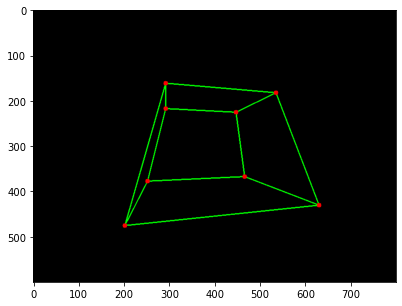

In [15]:
plt.imshow(draw_pyramid(points2d_0))

Во второй момент времени камера перемещается. Перемещение определено вектором параллельного переноса и матрицей вращения, заданными _в системе координат камеры_:

In [16]:
tvec_movement = np.array([0, -2, 0])
rmat_movement = euler2mat(np.deg2rad(-30), 0, 0)

Создайте матрицу `view_proj_1`, с помощью которой можно производить проецирование нашей камерой уже в новой позиции.

In [17]:
cam_movement = rmat_and_tvec_to_mat4x4(rmat_movement, tvec_movement)
view_proj_1 = proj_mat @ np.linalg.inv(cam_movement) @ np.linalg.inv(cam_pose_0)

Спроецируем нашу пирамиду из второй позиции и проверим, правильно ли получилось.

In [18]:
points2d_1 = project_points3d(VERTICES, view_proj_1)
assert np.linalg.norm(POINTS2D_1_GT - points2d_1) < 1e-5

Нарисуем картинку.

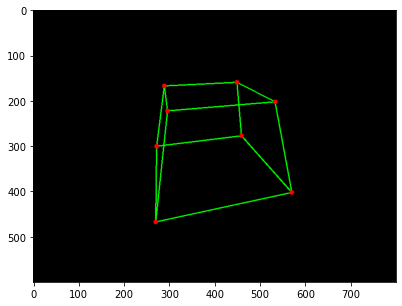

In [19]:
plt.imshow(draw_pyramid(points2d_1))

## Direct Linear Transform

### Задача 3. Построение и использование матрицы гомографии

Реализуйте функцию `calc_homography_mat3x3` для вычисления матрицы гомографии, переводящей массив точек `points_from` размерности `(4, 2)` в массив точек `points_to` такой же размерности.

In [20]:
def calc_homography_mat3x3(points_from, points_to):
    x = points_from[:, 0].reshape(-1, 1)
    y = points_from[:, 1].reshape(-1, 1)
    u = points_to[:, 0].reshape(-1, 1)
    v = points_to[:, 1].reshape(-1, 1)
    one = np.ones_like(x)
    zero3 = np.zeros((x.shape[0], 3))
    mat = np.vstack((
        np.hstack((x, y, one, zero3, -u * x, - u * y, -u)),
        np.hstack((zero3, x, y, one, -v * x, -v * y, -v)),
    ))
    u, s, vh = np.linalg.svd(mat)
    hvec = vh[-1, :]
    hmat =  hvec.reshape(3, 3)
    return hmat

Реализуйте функцию `apply_homography`, применяющую матрицу гомографии размерности `(3, 3)` к точкам, заданным массивом размерности `(N, 2)`.

In [21]:
def apply_homography(points2d, hmat):
    points3d = np.hstack((points2d, np.ones((points2d.shape[0], 1))))
    points3d = (hmat @ points3d.T).T
    points3d /= points3d[:, 2].reshape((-1, 1))
    return points3d[:, :2]

Протестируем то, что получилось, на точках усеченной пирамиды из предыдущего задания. Мы берем фронтальную по отношению к нам грань.

In [22]:
points_from = POINTS2D_0_GT[[1, 5, 2, 6]]
points_to = POINTS2D_1_GT[[1, 5, 2, 6]]
hmat = calc_homography_mat3x3(points_from, points_to)
assert np.linalg.norm(apply_homography(points_from, hmat) - points_to) < 1e-5

Посмотрим, что наша матрица `hmat` делает со всем изображением с помощью `cv2.warpPerspective`.

In [23]:
def draw_warping(hmat):
    pose_0_img = draw_pyramid(POINTS2D_0_GT, edge_color=(1, 0, 1), vertex_color=(0, 1, 0))
    pose_1_img = draw_pyramid(POINTS2D_1_GT)
    warped = cv2.warpPerspective(
        pose_0_img,
        hmat,
        (IMG_WIDTH, IMG_HEIGHT)
    )
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))
    ax1.imshow(pose_0_img)
    ax2.imshow(pose_1_img)
    ax3.imshow(pose_1_img + warped)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


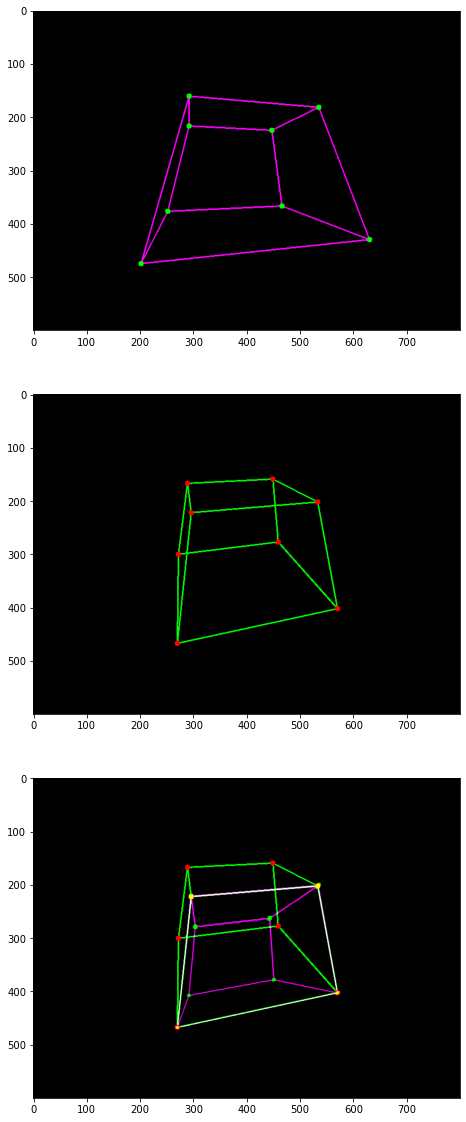

In [24]:
draw_warping(hmat)

Мы видим, что ничего супер интересного не произошло — всё содержимое фронтальной грани первой проекции уместилось во фронтальную грань второй проекции. Но можно сделать что-нибудь повеселее с бесконечностью...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


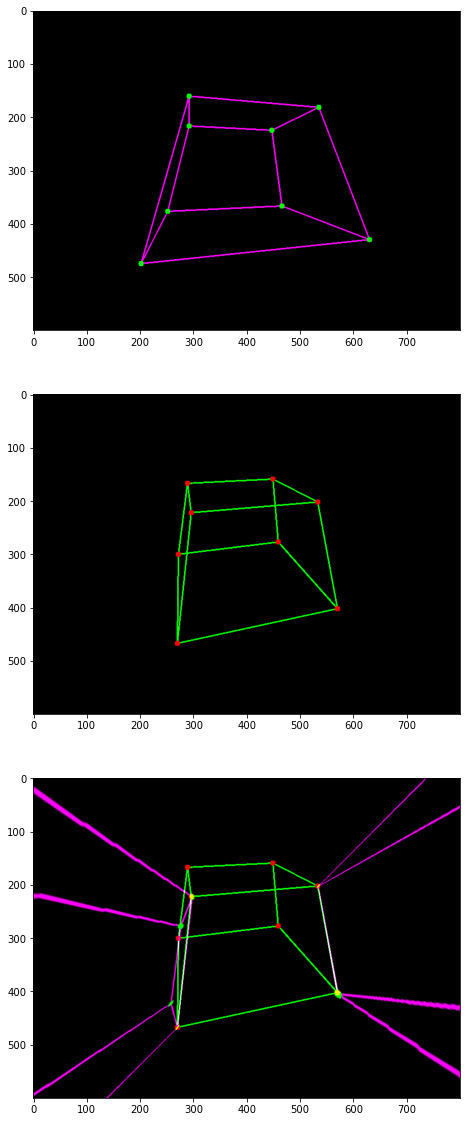

In [25]:
draw_warping(calc_homography_mat3x3(
    POINTS2D_0_GT[[1, 5, 2, 6]],
    POINTS2D_1_GT[[1, 5, 6, 2]]
))


## Перспективные преобразования плоскости

Вспомогательные функции для чтения RGB изображения, а также отрисовки двумерных точек на изображении различными цветами:

In [26]:
def read_rgb_img(path):
    img = cv2.imread(path)
    img = (img / 255.0).astype(np.float32)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def draw_points(img, points, colors, radius=5):
    assert len(points) == len(colors)
    output_img = img.copy()
    for pt, color in zip(points, colors):
        cv2.circle(output_img, tuple(pt.astype(int)), radius,
                   color, thickness=cv2.FILLED)
    return output_img


def generate_colors(count):
    hues = np.linspace(0, 1, count, endpoint=False)
    colors = []
    for h in hues:
        colors.append(colorsys.hsv_to_rgb(h, 1, 1))
    return colors


CORNERS_COLORS = generate_colors(4)

### Задача 4. Замена обложки книги на изображении на другое изображение

Загрузим необходимые данные.

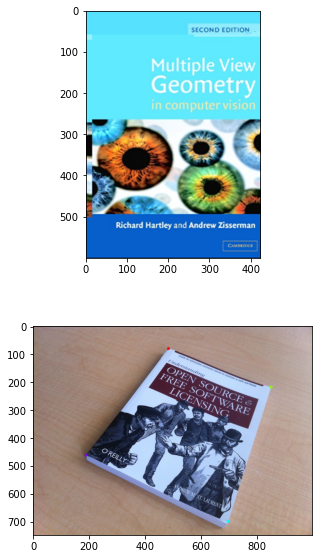

In [37]:
src_img = read_rgb_img('./data/hz_cover.png')

dst_img = read_rgb_img('./data/book_perspective.jpg')
dst_corners = np.array([[485, 80], [853, 218], [698, 698], [190, 461]])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))
ax1.imshow(src_img)
ax2.imshow(draw_points(dst_img, dst_corners, CORNERS_COLORS))

Реализуйте функцию `insert_image_above_corners`, которая рисует изображение `src_img` поверх изображения `dst_img` в области, ограниченной углами `dst_corners` (массив размерности `(4, 2)`).

In [50]:
def insert_image_above_corners(src_img, dst_img, dst_corners):
    src_h, src_w, _ = src_img.shape
    src_corners = np.array([
        [0.0, 0.0],
        [src_w - 1, 0.0],
        [src_w - 1, src_h - 1],
        [0.0, src_h - 1]
    ])
    hmat = calc_homography_mat3x3(src_corners, dst_corners)
    dst_h, dst_w, _ = dst_img.shape

    res_img = cv2.warpPerspective(src_img, hmat, (dst_w, dst_h))
    mask = np.zeros(res_img.shape)
    mask[res_img > 0] = 1
    res_img = mask * res_img + (1 - mask) * dst_img
    return res_img

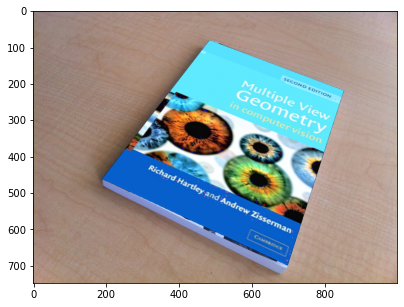

In [51]:
plt.imshow(insert_image_above_corners(src_img, dst_img, dst_corners))

### Задача 5*. Генерация анимации из пары изображений, полученных вращающейся камерой

Дана пара изображений кубика, полученных вращением камеры на неизвестный угол вокруг неизветной оси, а также координаты четырех уголков кубика на каждом изображении.

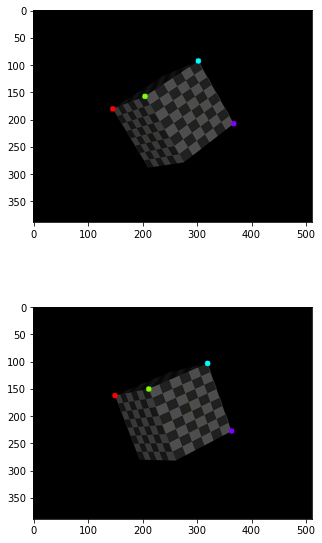

In [30]:
src_img = read_rgb_img('./data/rot1.jpg')
src_corners = np.array([
    [146.25, 181.0],
    [205.0, 158.5],
    [303.5, 93.5],
    [368.5, 208.0]
])
dst_img = read_rgb_img('./data/rot2.jpg')
dst_corners = np.array([
    [150.25, 162.25],
    [212.0, 150.25],
    [320.25, 103.25],
    [364.5, 227.5]
])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))
ax1.imshow(draw_points(src_img, src_corners, CORNERS_COLORS))
ax2.imshow(draw_points(dst_img, dst_corners, CORNERS_COLORS))

Между изображениями `src_img` и `dst_img`, полученными вращением камеры на некторой неизвестный угол $\alpha$ вокруг некоторой оси, существует гомография. Посчитайте такую гомографию `hmat`.

Используя полученную матрицу, вычислите гомографию `hmat2`, которая бы существовала между `src_img` и гипотетическим изображением, полученным вращением камеры на угол $2 \alpha$ вокруг той же оси. Подсказка: воспользуйтесь уравнением проекции с матрицей проекции в виде $3 \times 3$.

Также вычислите гомографию `hmat3`, соответствующую углу $3 \alpha$.

In [31]:
hmat = calc_homography_mat3x3(src_corners, dst_corners)
hmat2 = hmat @ hmat
hmat3 = hmat2 @ hmat

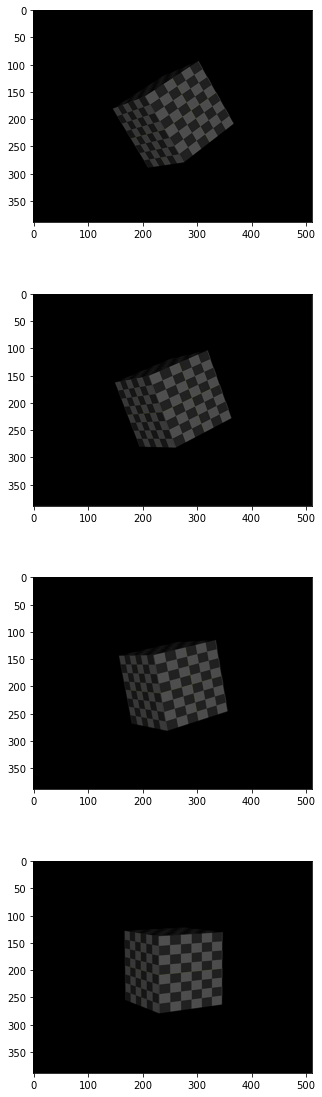

In [32]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5, 20))
ax1.imshow(src_img)
ax2.imshow(dst_img)
h, w, _ = src_img.shape
ax3.imshow(cv2.warpPerspective(src_img, hmat2, (w, h)))
ax4.imshow(cv2.warpPerspective(src_img, hmat3, (w, h)))